In [1]:
import foldable_robotics.dxf as frd
import foldable_robotics as fr
import foldable_robotics.manufacturing as frm
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.parts.castellated_hinge2 as frc
import shapely.geometry as sg
from foldable_robotics.pdf import Page
import foldable_robotics.pdf as frp
import socket
import foldable_robotics.parts.pill_joint as frpill
import foldable_robotics.plotter_support as frplt

In [2]:
fr.display_height=300
fr.resolution = 4
desired_degrees = 120
thickness = 1
plain_width = frm.plain_hinge_width(desired_degrees,thickness)
plain_width

1.7320508075688774

All of this is from the given code example 

In [3]:
support_width = 2 # must be larger than hinge width
kerf = .05
is_adhesive = [False,True,False,True,False]
arc_approx = 10
NUM_LAYERS = 5
bridge_thickness = 2
bounding_box_padding = 10
jig_spacing = 10
jig_dia = 5


As is this code above. 

In [4]:
body_vertices = frd.read_lwpolylines('ostrichlegforreal.dxf', layer='body',arc_approx = arc_approx)
body_vertices

[[[50.00940537840764, 368.0045980266],
  [93.40940537840761, 368.0045980266],
  [93.4094053784076, 120.0045980266],
  [81.00940537840762, 120.0045980266],
  [81.00940537840762, 98.30459802659999],
  [62.4094053784076, 98.30459802659999],
  [62.4094053784076, 120.0045980266],
  [50.0, 120.0],
  [50.00940537840764, 368.0045980266]]]

From the drawing file of the dxf we are able to create the body_vertices. This is also like the example 

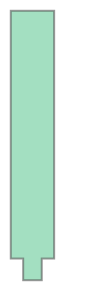

In [5]:
body_polygons = [sg.Polygon(item) for item in body_vertices]
body_polygons[0]

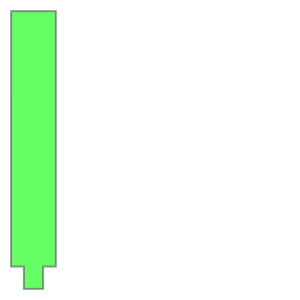

In [6]:
body_layer = Layer(*body_polygons)
body_layer

Creates the layer. 

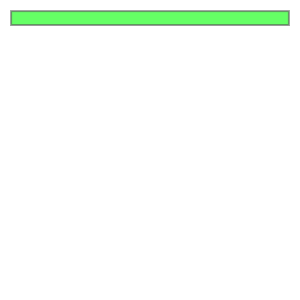

In [7]:
hole_vertices = frd.read_lwpolylines('ostrichlegforreal.dxf',layer='holes',arc_approx = arc_approx)
hole_layer = Layer(*[sg.Polygon(item) for item in hole_vertices])
hole_layer

Creates the holes on the layer.

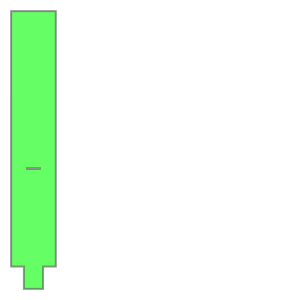

In [8]:
body_layer -= hole_layer
body_layer

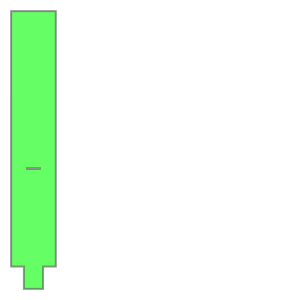

In [9]:
cut_vertices = frd.read_lwpolylines('ostrichleg.dxf',layer='cuts', arc_approx = arc_approx)
cut_layer = Layer(*[sg.LineString(item) for item in cut_vertices])
cut_layer
cut_layer <<=.5
cut_layer
body_layer -= cut_layer
body_layer

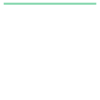

In [10]:
joint_vertices = frd.read_lwpolylines('ostrichlegforreal.dxf',layer='joints',arc_approx = arc_approx)
l = sg.LineString(joint_vertices[0])
l

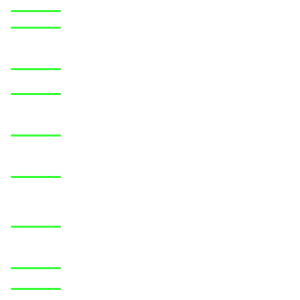

In [11]:
joint_lines_original_layer = Layer(*[sg.LineString(item) for item in joint_vertices])
joint_lines_original_layer

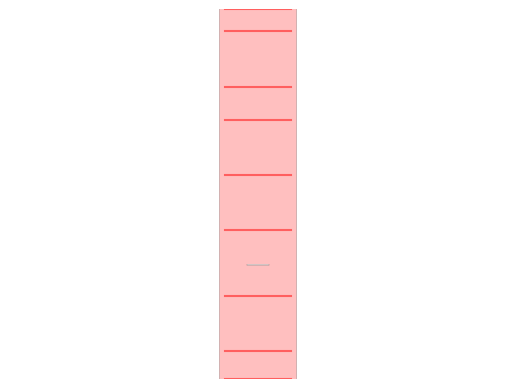

In [12]:
body_layer.plot()
joint_lines_original_layer.plot()

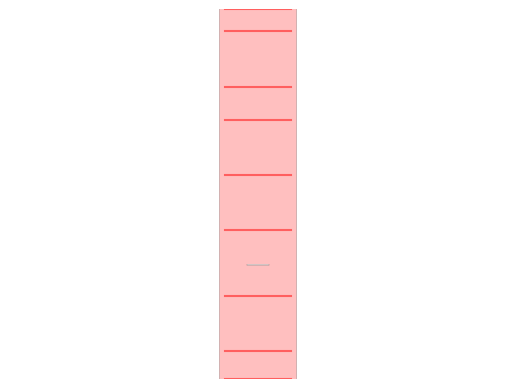

In [13]:
joint_lines_modified_layer = joint_lines_original_layer & body_layer
body_layer.plot()
joint_lines_modified_layer.plot()

In [14]:
modified_joint_vertices = [list(item.coords) for item in joint_lines_modified_layer.geoms]
modified_joint_vertices

[[(53.1094053784076, 346.3045980266), (90.30940537840759, 346.3045980266)],
 [(53.1094053784076, 358.7045980266), (90.30940537840759, 358.7045980266)],
 [(53.1094053784076, 315.3045980266), (90.30940537840759, 315.3045980266)],
 [(53.1094053784076, 296.7045980266), (90.30940537840759, 296.7045980266)],
 [(53.1094053784076, 265.7045980266), (90.30940537840759, 265.7045980266)],
 [(53.10940537840759, 234.7045980266), (90.30940537840759, 234.7045980266)],
 [(53.10940537840759, 197.5045980266), (90.30940537840758, 197.5045980266)],
 [(53.10940537840759, 166.5045980266), (90.30940537840758, 166.5045980266)],
 [(53.10940537840759, 151.0045980266), (90.30940537840758, 151.0045980266)]]

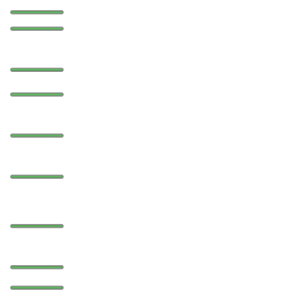

In [15]:
simple_joint_layer = joint_lines_modified_layer << plain_width/2
simple_joint_layer

In [16]:
hole,dummy = frm.calc_hole(modified_joint_vertices,plain_width/2)
fr.my_line_width=0
holes = hole.to_laminate(NUM_LAYERS)
holes<<=.5 
holes

<Figure size 640x480 with 0 Axes>

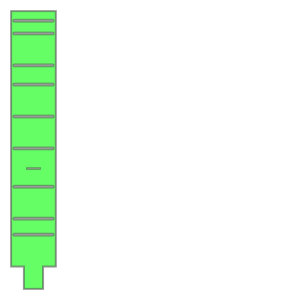

In [17]:
rigid_layer = (body_layer - simple_joint_layer)
rigid_layer

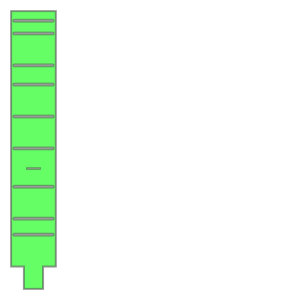

In [18]:
adhesive_layer = rigid_layer & body_layer
adhesive_layer

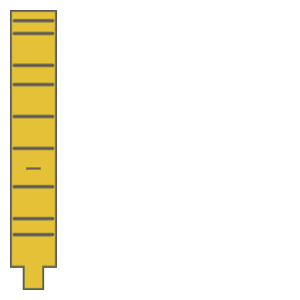

In [19]:
ideal_final_device = Laminate(rigid_layer,adhesive_layer, body_layer,
adhesive_layer,rigid_layer)
ideal_final_device

Creates the adhesive layer.

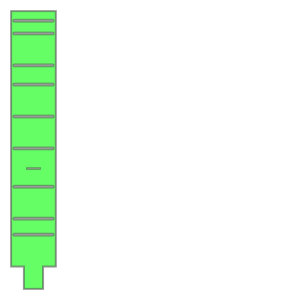

In [20]:
ideal_final_device[0]

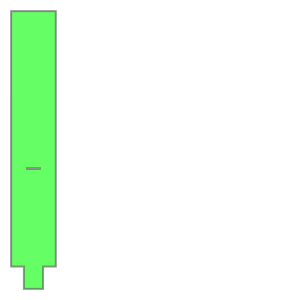

In [21]:
ideal_final_device[2]

In [22]:
bridges = frd.read_lines('ostrichlegforreal.dxf', layer='bridge')
bridges


[]

In [23]:
bridges_layer = Layer(*[sg.LineString(item) for item in bridges])
bridges_layer <<= bridge_thickness
bridges_layer

In [24]:
bridges_lam = Laminate(bridges_layer,bridges_layer,Layer(),bridges_layer,bridges_layer)
bridges_lam

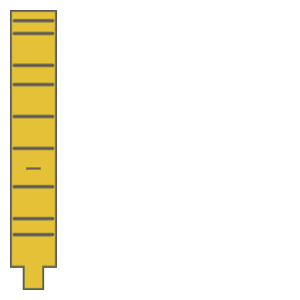

In [25]:
supported_actual_device = ideal_final_device | bridges_lam
supported_actual_device

In [26]:
diff = supported_actual_device - ideal_final_device
removal = frm.cleanup(diff, .1)
removal

In [27]:
removal = frm.keepout_laser(removal)
removal

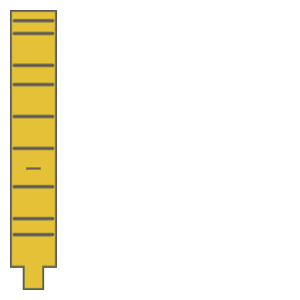

In [28]:
actual_final_device = ideal_final_device- holes - removal
actual_final_device

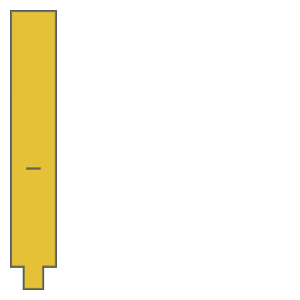

In [29]:
keepout = frm.keepout_laser(actual_final_device)
keepout

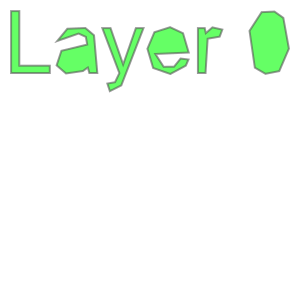

In [30]:
layer_id = frm.build_layer_numbers(NUM_LAYERS,
text_size=jig_dia)
layer_id = layer_id.simplify(.2)
layer_id[0]

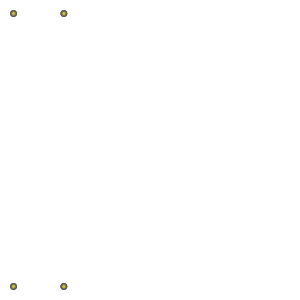

In [31]:
(x1,y1),(x2,y2) = actual_final_device.bounding_box_coords()
w1,h1 = actual_final_device.get_dimensions()
w2 = round(w1/jig_spacing)*jig_spacing+jig_spacing+support_width
h2 = round(h1/jig_spacing)*jig_spacing+jig_spacing+support_width
x1 -= (w2-w1)/2
y1 -= (h2-h1)/2
x2 += (w2-w1)/2
y2 += (h2-h1)/2
points = []
points.append(sg.Point(x1,y1))
points.append(sg.Point(x2,y1))
points.append(sg.Point(x1,y2))
points.append(sg.Point(x2,y2))
alignment_holes_layer = Layer(*points)
alignment_holes_layer<<=(jig_dia/2)
alignment_holes=alignment_holes_layer.to_laminate(NUM_LAYERS)
alignment_holes

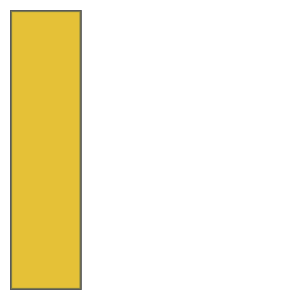

In [32]:
sheet_layer = (alignment_holes_layer<<bounding_box_padding).bounding_box()
sheet=sheet_layer.to_laminate(NUM_LAYERS)
sheet

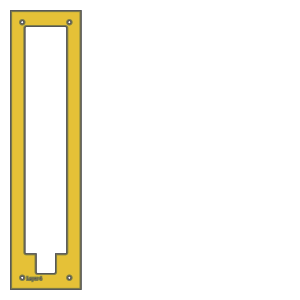

In [33]:
removable_scrap = frm.calculate_removable_scrap(
actual_final_device,sheet,support_width,is_adhesive)
web = removable_scrap-alignment_holes-layer_id.translate(x1+jig_dia,y1-jig_dia/2)
web

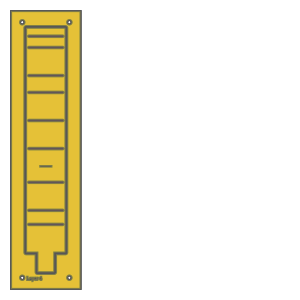

In [34]:
(web|actual_final_device)

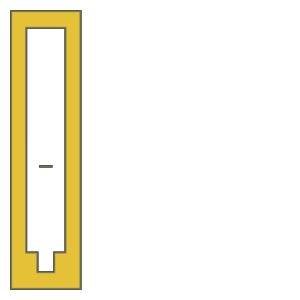

In [35]:
second_pass_scrap = sheet-keepout
second_pass_scrap

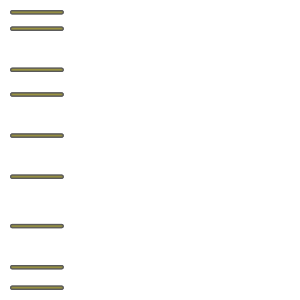

In [36]:
first_pass_scrap = sheet - second_pass_scrap - actual_final_device
first_pass_scrap = frm.cleanup(first_pass_scrap,.00001)
first_pass_scrap

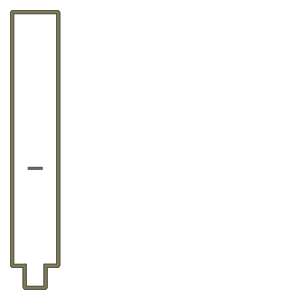

In [37]:
support = frm.support(actual_final_device,frm.keepout_laser,support_width,support_width/2)
support

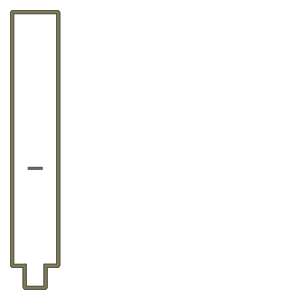

In [38]:
support | bridges_lam

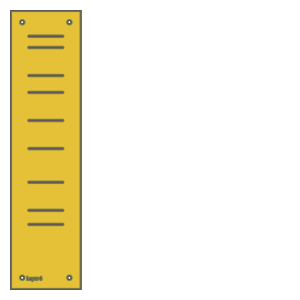

In [39]:
supported_design = web|actual_final_device|support| bridges_lam
supported_design

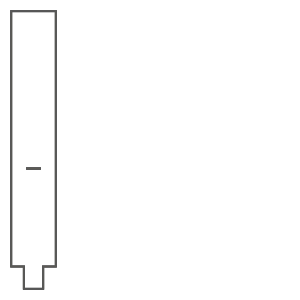

In [40]:
cut_material = (keepout<<kerf)-keepout
cut_material

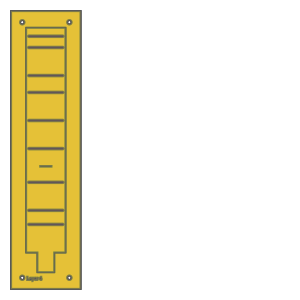

In [41]:
remaining_material = supported_design-cut_material
remaining_material

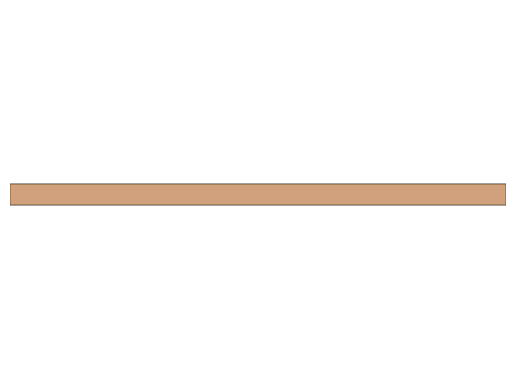

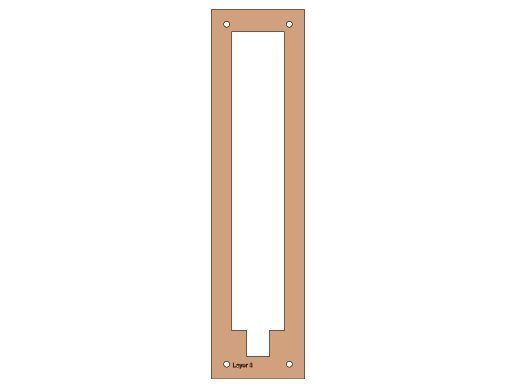

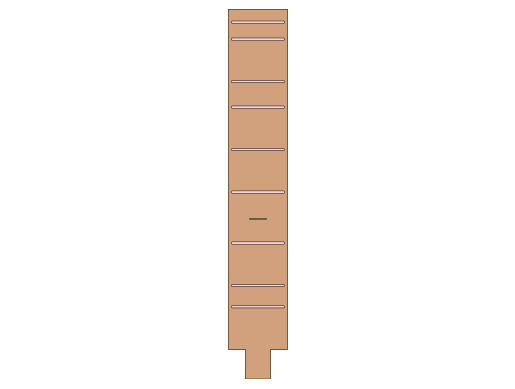

In [42]:
remaining_parts = frm.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)

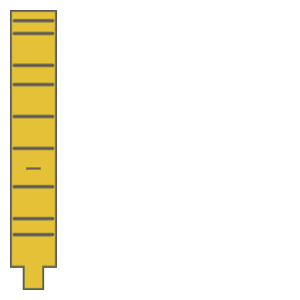

In [43]:
test_part=actual_final_device>>1
for result in remaining_parts:
    if not (result&test_part).is_null():
        break
result

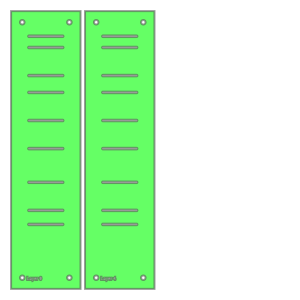

In [44]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()
rigid_layer = supported_design[0] | (supported_design[-1].translate(w+5,0))
rigid_layer

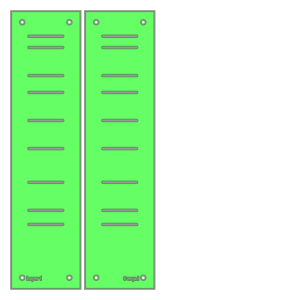

In [45]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+w+5,p0[1]-p2[1])
adhesive_layer = supported_design[1] | l4
adhesive_layer

In [46]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])
first_pass.export_dxf('first_pass')

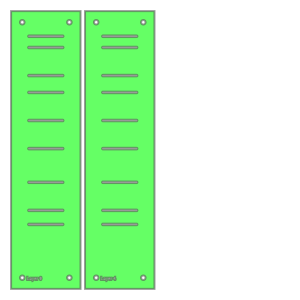

In [47]:
first_pass[0]

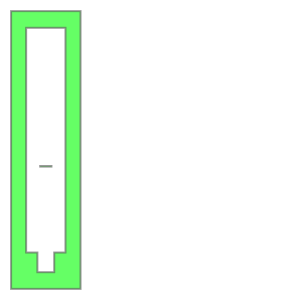

In [48]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.export_dxf('final_cut')
final_cut

In [49]:
final_cut_scaled=first_pass[0].scale(1/25.4,1/25.4)
(x,y),(_,_) = final_cut_scaled.bounding_box_coords()
final_cut_scaled = final_cut_scaled.translate(-x,-y)
final_cut_scaled.bounding_box_coords()

[(np.float64(0.0), np.float64(0.0)),
 (np.float64(6.229583118745245), np.float64(12.07148447275845))]

In [50]:
final_cut_scaled.exteriors()


[[(0.0, 12.07148447275845),
  (3.016366362522229, 12.07148447275845),
  (3.016366362522229, 0.0),
  (0.0, 0.0),
  (0.0, 12.07148447275845)],
 [(3.213216756223016, 12.07148447275845),
  (6.229583118745245, 12.07148447275845),
  (6.229583118745245, 0.0),
  (3.213216756223016, 0.0),
  (3.213216756223016, 12.07148447275845)]]

In [51]:

s = frplt.layer_string(final_cut_scaled)
my_bytes= s.encode()
my_bytes

b'IN;P0;U0,0;D0,12071;D3016,12071;D3016,0;D0,0;U485,386;D522,394;D554,415;D575,447;D583,485;D575,522;D554,554;D522,575;D485,583;D447,575;D415,554;D394,522;D386,485;D394,447;D415,415;D447,394;D485,386;U2532,386;D2569,394;D2601,415;D2623,447;D2630,485;D2623,522;D2601,554;D2569,575;D2532,583;D2494,575;D2462,554;D2441,522;D2433,485;D2441,447;D2462,415;D2494,394;D2532,386;U485,11488;D522,11496;D554,11517;D575,11549;D583,11587;D575,11625;D554,11657;D522,11678;D485,11685;D447,11678;D415,11657;D394,11625;D386,11587;D394,11549;D415,11517;D447,11496;D485,11488;U2532,11488;D2569,11496;D2601,11517;D2623,11549;D2630,11587;D2623,11625;D2601,11657;D2569,11678;D2532,11685;D2494,11678;D2462,11657;D2441,11625;D2433,11587;D2441,11549;D2462,11517;D2494,11496;D2532,11488;U951,405;D922,488;D904,488;D942,386;D932,365;D915,362;D921,345;D947,358;D997,488;D980,488;D951,405;U821,385;D859,391;D870,399;D874,386;D892,386;D885,472;D865,489;D824,487;D801,459;D850,476;D866,468;D869,451;D810,437;D799,404;D821,385;U1058

In [56]:
host = '192.168.0.151'
port = 8080
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((host, port))
s.sendall(my_bytes)
s.close()
